In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as colormap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import time
import torchvision.models as models
import copy

In [2]:
class dataset(Dataset):
    def __init__(self, images_dir, transform, device):
        self.images_dir = images_dir
        self.transform = transform
        self.device = device
        self.class_names = sorted(os.listdir(self.images_dir))
        self.image_paths = []
        self.labels = []
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(self.images_dir, class_name)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(i)
        self.device = device
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = cv2.imread(image_path)
        image = self.transform(image).to(self.device)
        label = torch.LongTensor([label]).to(self.device)
        return image, label

In [3]:
def plot_data_loader(data_loader, gridDims, class_names):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, labels = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
            axes[i, j].set_title(class_names[labels[0]])
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        labels = labels.reshape(-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [5]:
def val_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc

In [6]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    all_probs = []
    all_labelsForProbs = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            labels = labels.reshape(-1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labelsForProbs.append(labels.cpu().numpy())
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds += preds.cpu().numpy().tolist()
            all_labels += labels.cpu().numpy().tolist()
    all_probs = np.concatenate(all_probs)
    all_labelsForProbs = np.concatenate(all_labelsForProbs)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    epoch_classification_report = classification_report(all_labels, all_preds)
    print(f'Test Results:')
    print(f'Test Accuracy: {epoch_acc:.4f}')
    print(f'\n{epoch_classification_report}')
    cm = confusion_matrix(all_labels, all_preds)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_data.class_names, yticklabels=test_data.class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    n_classes = len(test_data.class_names)
    y_test = label_binarize(all_labelsForProbs, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(y_test[:, i], all_probs[:, i], average='macro')
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), all_probs.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, all_probs, average="micro")
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=4)
    label_names = test_data.class_names
    cmap = colormap.get_cmap('tab20',len(label_names))
    colors = [cmap(i) for i in range(len(label_names))]
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label=f'{test_data.class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

--------------------------------------------------------------------------------------------------------
FER2013
--------------------------------------------------------------------------------------------------------
train_images: 3208
val_images: 809
test_images: 1020


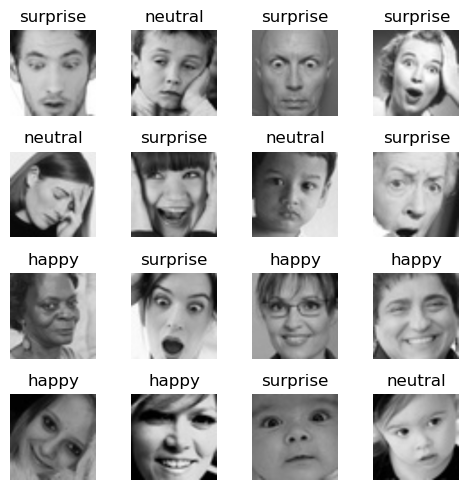

--------------------------------------------------------------------------------------------------------
resnet18_FER2013
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 990.436 billion


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


Epoch 1/25 | Train Loss: 1.2138 | Train Acc: 0.4193 | Val Loss: 1.0840 | Val Acc: 0.3449


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 2/25 | Train Loss: 1.0043 | Train Acc: 0.4850 | Val Loss: 2.0181 | Val Acc: 0.3548


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch 3/25 | Train Loss: 0.9305 | Train Acc: 0.5355 | Val Loss: 4.5319 | Val Acc: 0.3412


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 4/25 | Train Loss: 0.9803 | Train Acc: 0.5081 | Val Loss: 1.2223 | Val Acc: 0.4536


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch 5/25 | Train Loss: 0.8579 | Train Acc: 0.5701 | Val Loss: 1.4328 | Val Acc: 0.3894


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 6/25 | Train Loss: 0.7176 | Train Acc: 0.6842 | Val Loss: 1.5886 | Val Acc: 0.3412


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 7/25 | Train Loss: 0.6784 | Train Acc: 0.7029 | Val Loss: 1.2135 | Val Acc: 0.4302


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 8/25 | Train Loss: 0.6337 | Train Acc: 0.7335 | Val Loss: 1.0839 | Val Acc: 0.4870


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 9/25 | Train Loss: 0.5432 | Train Acc: 0.7802 | Val Loss: 0.8066 | Val Acc: 0.5847


100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 10/25 | Train Loss: 0.5500 | Train Acc: 0.7712 | Val Loss: 2.2799 | Val Acc: 0.3399


100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 11/25 | Train Loss: 0.5649 | Train Acc: 0.7771 | Val Loss: 1.9853 | Val Acc: 0.3807


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch 12/25 | Train Loss: 0.4945 | Train Acc: 0.8030 | Val Loss: 2.1550 | Val Acc: 0.4351


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 13/25 | Train Loss: 0.5075 | Train Acc: 0.7896 | Val Loss: 1.3644 | Val Acc: 0.5352


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 14/25 | Train Loss: 0.4296 | Train Acc: 0.8335 | Val Loss: 0.4951 | Val Acc: 0.7639


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 15/25 | Train Loss: 0.3969 | Train Acc: 0.8404 | Val Loss: 1.6999 | Val Acc: 0.4574


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 16/25 | Train Loss: 0.3500 | Train Acc: 0.8678 | Val Loss: 0.6345 | Val Acc: 0.6601


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Epoch 17/25 | Train Loss: 0.5275 | Train Acc: 0.7924 | Val Loss: 0.8579 | Val Acc: 0.5810


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 18/25 | Train Loss: 0.4348 | Train Acc: 0.8345 | Val Loss: 0.4527 | Val Acc: 0.7800


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch 19/25 | Train Loss: 0.4000 | Train Acc: 0.8479 | Val Loss: 0.4572 | Val Acc: 0.7701


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 20/25 | Train Loss: 0.3691 | Train Acc: 0.8613 | Val Loss: 0.7258 | Val Acc: 0.6761


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Epoch 21/25 | Train Loss: 0.3862 | Train Acc: 0.8550 | Val Loss: 0.4094 | Val Acc: 0.7973


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 22/25 | Train Loss: 0.2843 | Train Acc: 0.8943 | Val Loss: 0.5071 | Val Acc: 0.7515


100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Epoch 23/25 | Train Loss: 0.2509 | Train Acc: 0.9068 | Val Loss: 0.4793 | Val Acc: 0.7726


100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 24/25 | Train Loss: 0.2684 | Train Acc: 0.8981 | Val Loss: 1.0674 | Val Acc: 0.6304


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 25/25 | Train Loss: 0.2821 | Train Acc: 0.8921 | Val Loss: 0.6309 | Val Acc: 0.7169
Average time per epoch: 16.00 seconds


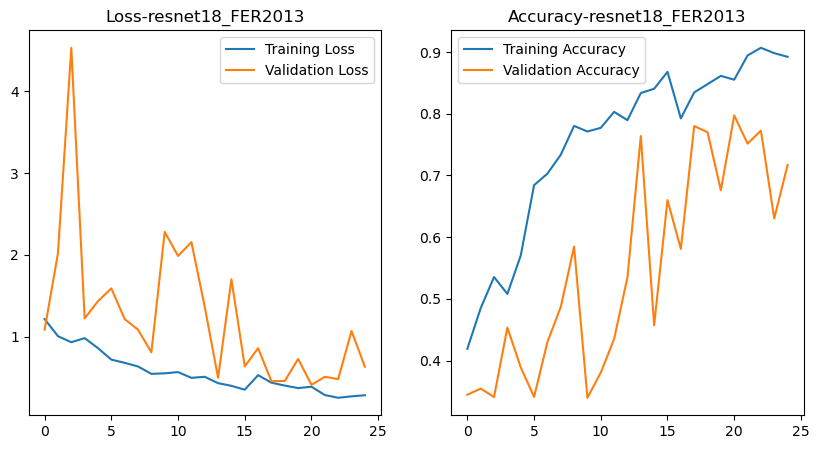

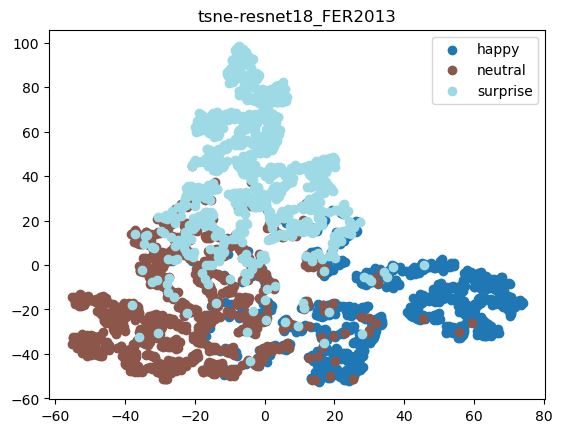

100%|██████████| 8/8 [00:06<00:00,  1.21it/s]

Test Results:
Test Accuracy: 0.7412

              precision    recall  f1-score   support

           0       0.82      0.61      0.70       340
           1       0.66      0.84      0.74       340
           2       0.79      0.78      0.79       340

    accuracy                           0.74      1020
   macro avg       0.76      0.74      0.74      1020
weighted avg       0.76      0.74      0.74      1020



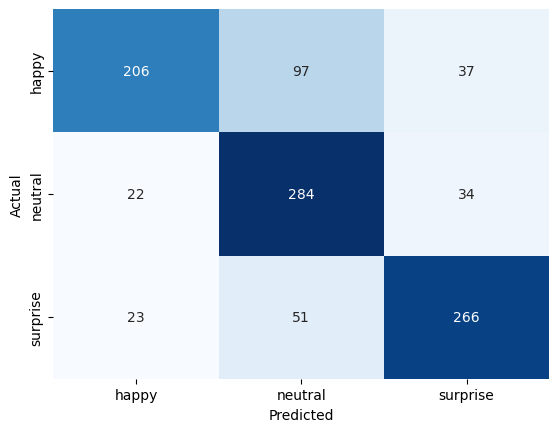

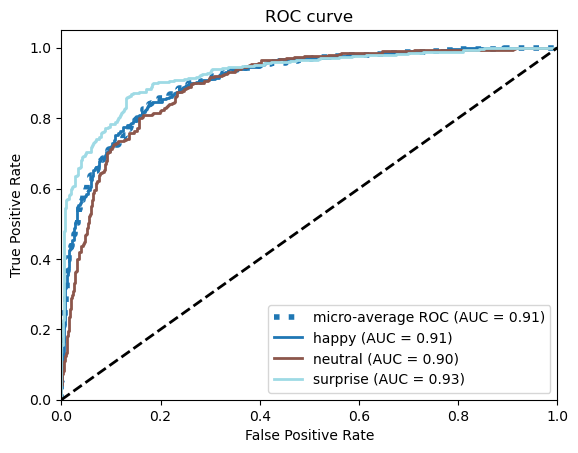

--------------------------------------------------------------------------------------------------------
mobilenet_v2_FER2013
--------------------------------------------------------------------------------------------------------


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip


Device: cuda
FLOPS: 4018.565 billion


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 1/25 | Train Loss: 1.0863 | Train Acc: 0.4043 | Val Loss: 1.1970 | Val Acc: 0.3337


100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Epoch 2/25 | Train Loss: 1.0643 | Train Acc: 0.4339 | Val Loss: 1.3218 | Val Acc: 0.3325


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 3/25 | Train Loss: 0.9870 | Train Acc: 0.5069 | Val Loss: 0.8729 | Val Acc: 0.3881


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 4/25 | Train Loss: 0.9044 | Train Acc: 0.5680 | Val Loss: 0.9584 | Val Acc: 0.5006


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 5/25 | Train Loss: 0.8216 | Train Acc: 0.6368 | Val Loss: 0.9008 | Val Acc: 0.5414


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Epoch 6/25 | Train Loss: 0.7303 | Train Acc: 0.6852 | Val Loss: 0.5785 | Val Acc: 0.6811


100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 7/25 | Train Loss: 0.6731 | Train Acc: 0.7179 | Val Loss: 0.6322 | Val Acc: 0.6477


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 8/25 | Train Loss: 0.5757 | Train Acc: 0.7634 | Val Loss: 0.6278 | Val Acc: 0.6860


100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 9/25 | Train Loss: 0.5613 | Train Acc: 0.7715 | Val Loss: 0.6820 | Val Acc: 0.6712


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 10/25 | Train Loss: 0.5119 | Train Acc: 0.7936 | Val Loss: 0.5514 | Val Acc: 0.7515


100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Epoch 11/25 | Train Loss: 0.5456 | Train Acc: 0.7802 | Val Loss: 0.5329 | Val Acc: 0.7293


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 12/25 | Train Loss: 0.4665 | Train Acc: 0.8173 | Val Loss: 0.5759 | Val Acc: 0.7281


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 13/25 | Train Loss: 0.4253 | Train Acc: 0.8320 | Val Loss: 0.5667 | Val Acc: 0.7231


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch 14/25 | Train Loss: 0.3905 | Train Acc: 0.8516 | Val Loss: 0.5712 | Val Acc: 0.7318


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Epoch 15/25 | Train Loss: 0.3531 | Train Acc: 0.8694 | Val Loss: 0.5351 | Val Acc: 0.7701


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 16/25 | Train Loss: 0.3720 | Train Acc: 0.8650 | Val Loss: 0.5151 | Val Acc: 0.7540


100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 17/25 | Train Loss: 0.3629 | Train Acc: 0.8597 | Val Loss: 0.5849 | Val Acc: 0.7367


100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 18/25 | Train Loss: 0.3009 | Train Acc: 0.8868 | Val Loss: 0.5238 | Val Acc: 0.7713


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 19/25 | Train Loss: 0.2153 | Train Acc: 0.9224 | Val Loss: 0.6346 | Val Acc: 0.7540


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch 20/25 | Train Loss: 0.2141 | Train Acc: 0.9252 | Val Loss: 0.6127 | Val Acc: 0.7614


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Epoch 21/25 | Train Loss: 0.2557 | Train Acc: 0.9055 | Val Loss: 0.7627 | Val Acc: 0.7169


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 22/25 | Train Loss: 0.3649 | Train Acc: 0.8669 | Val Loss: 0.5899 | Val Acc: 0.7491


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch 23/25 | Train Loss: 0.3004 | Train Acc: 0.8881 | Val Loss: 0.5620 | Val Acc: 0.7787


100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Epoch 24/25 | Train Loss: 0.1758 | Train Acc: 0.9364 | Val Loss: 0.5340 | Val Acc: 0.7726


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 25/25 | Train Loss: 0.1379 | Train Acc: 0.9486 | Val Loss: 0.7326 | Val Acc: 0.7466
Average time per epoch: 19.34 seconds


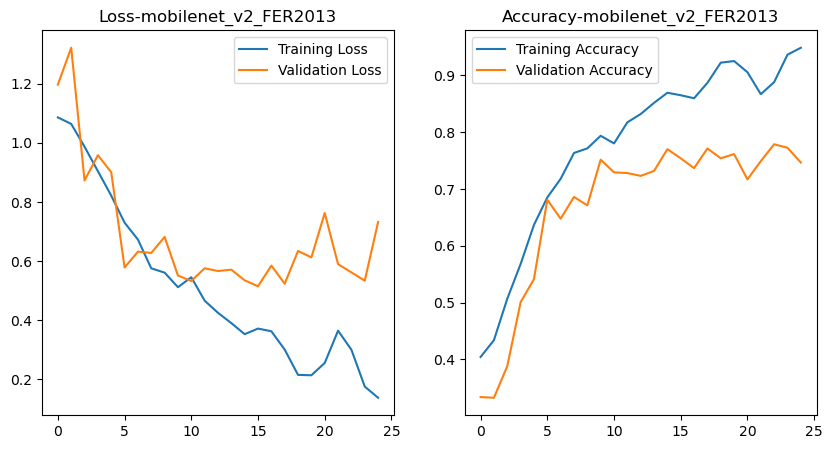

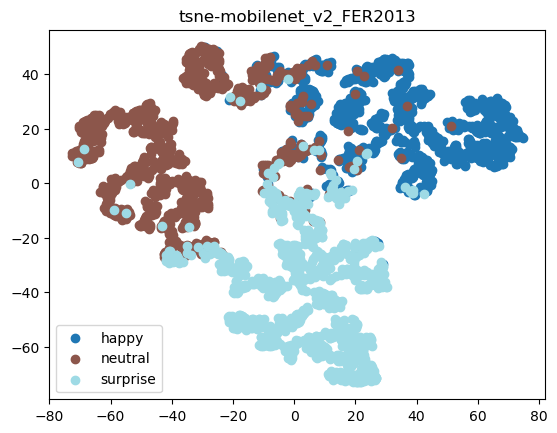

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

Test Results:
Test Accuracy: 0.7343

              precision    recall  f1-score   support

           0       0.66      0.78      0.72       340
           1       0.70      0.68      0.69       340
           2       0.87      0.74      0.80       340

    accuracy                           0.73      1020
   macro avg       0.74      0.73      0.74      1020
weighted avg       0.74      0.73      0.74      1020



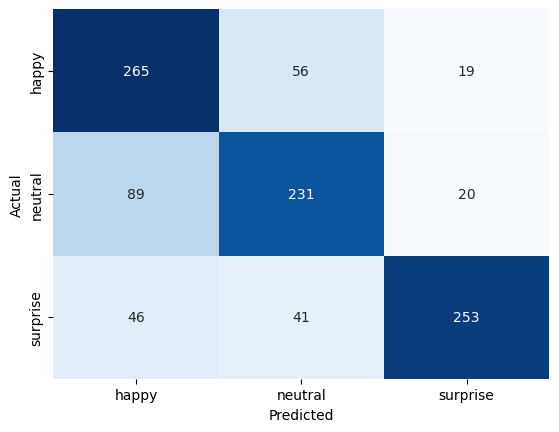

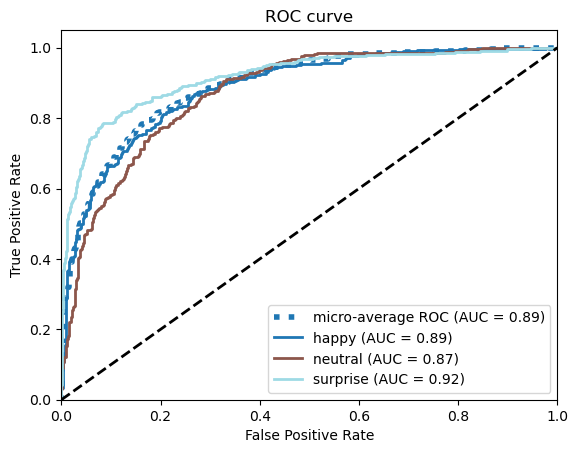

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


--------------------------------------------------------------------------------------------------------
shufflenet_v2_x1_0_FER2013
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 393.202 billion


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch 1/25 | Train Loss: 1.0877 | Train Acc: 0.4096 | Val Loss: 1.2814 | Val Acc: 0.3659


100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 2/25 | Train Loss: 1.0389 | Train Acc: 0.4620 | Val Loss: 0.9597 | Val Acc: 0.4054


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch 3/25 | Train Loss: 1.0018 | Train Acc: 0.4938 | Val Loss: 0.9577 | Val Acc: 0.3956


100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 4/25 | Train Loss: 0.9259 | Train Acc: 0.5421 | Val Loss: 0.7522 | Val Acc: 0.5575


100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 5/25 | Train Loss: 0.8391 | Train Acc: 0.6169 | Val Loss: 0.9969 | Val Acc: 0.4994


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch 6/25 | Train Loss: 0.7724 | Train Acc: 0.6621 | Val Loss: 0.8991 | Val Acc: 0.5624


100%|██████████| 7/7 [00:02<00:00,  3.40it/s]


Epoch 7/25 | Train Loss: 0.6962 | Train Acc: 0.7060 | Val Loss: 0.7035 | Val Acc: 0.6020


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Epoch 8/25 | Train Loss: 0.5970 | Train Acc: 0.7528 | Val Loss: 0.6407 | Val Acc: 0.6539


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch 9/25 | Train Loss: 0.5952 | Train Acc: 0.7550 | Val Loss: 0.7285 | Val Acc: 0.6489


100%|██████████| 7/7 [00:02<00:00,  3.39it/s]


Epoch 10/25 | Train Loss: 0.5201 | Train Acc: 0.7890 | Val Loss: 0.6638 | Val Acc: 0.6613


100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 11/25 | Train Loss: 0.4620 | Train Acc: 0.8139 | Val Loss: 0.6704 | Val Acc: 0.6749


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch 12/25 | Train Loss: 0.4786 | Train Acc: 0.8095 | Val Loss: 0.6778 | Val Acc: 0.6823


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 13/25 | Train Loss: 0.3871 | Train Acc: 0.8498 | Val Loss: 0.8136 | Val Acc: 0.6489


100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 14/25 | Train Loss: 0.4200 | Train Acc: 0.8329 | Val Loss: 0.9426 | Val Acc: 0.6403


100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 15/25 | Train Loss: 0.3954 | Train Acc: 0.8482 | Val Loss: 0.5835 | Val Acc: 0.7219


100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 16/25 | Train Loss: 0.3050 | Train Acc: 0.8834 | Val Loss: 0.7473 | Val Acc: 0.6897


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 17/25 | Train Loss: 0.2470 | Train Acc: 0.9071 | Val Loss: 0.7033 | Val Acc: 0.7108


100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 18/25 | Train Loss: 0.3090 | Train Acc: 0.8787 | Val Loss: 0.7218 | Val Acc: 0.7083


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Epoch 19/25 | Train Loss: 0.2458 | Train Acc: 0.9096 | Val Loss: 0.6891 | Val Acc: 0.7058


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 20/25 | Train Loss: 0.2014 | Train Acc: 0.9277 | Val Loss: 0.7094 | Val Acc: 0.7268


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch 21/25 | Train Loss: 0.1350 | Train Acc: 0.9523 | Val Loss: 0.7418 | Val Acc: 0.7231


100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 22/25 | Train Loss: 0.0962 | Train Acc: 0.9685 | Val Loss: 0.6783 | Val Acc: 0.7478


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Epoch 23/25 | Train Loss: 0.2499 | Train Acc: 0.9112 | Val Loss: 0.7801 | Val Acc: 0.6996


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


Epoch 24/25 | Train Loss: 0.2068 | Train Acc: 0.9264 | Val Loss: 0.7670 | Val Acc: 0.7169


100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 25/25 | Train Loss: 0.1684 | Train Acc: 0.9370 | Val Loss: 0.8681 | Val Acc: 0.6910
Average time per epoch: 14.53 seconds


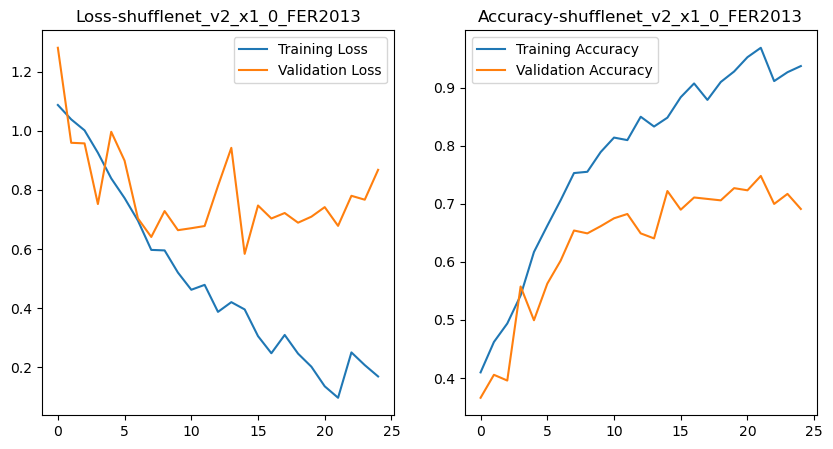

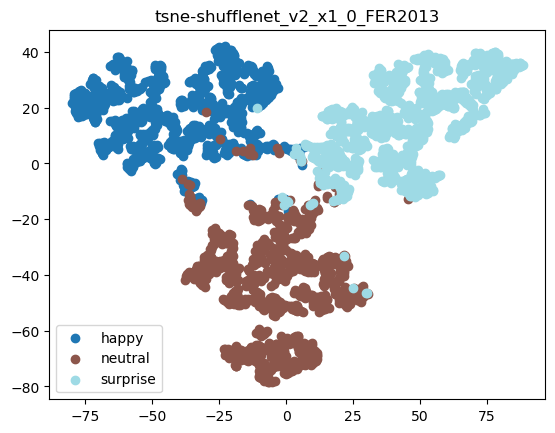

100%|██████████| 8/8 [00:03<00:00,  2.61it/s]


Test Results:
Test Accuracy: 0.7069

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       340
           1       0.70      0.61      0.65       340
           2       0.70      0.81      0.75       340

    accuracy                           0.71      1020
   macro avg       0.71      0.71      0.70      1020
weighted avg       0.71      0.71      0.70      1020



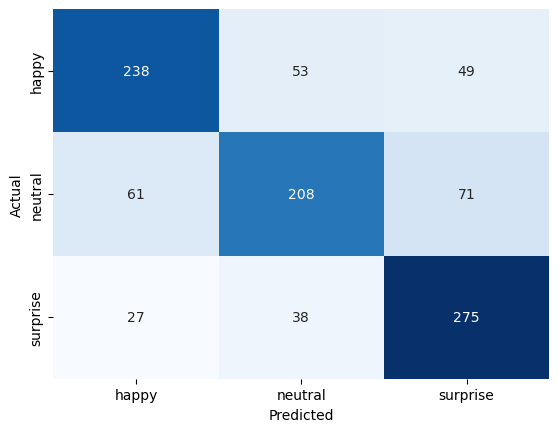

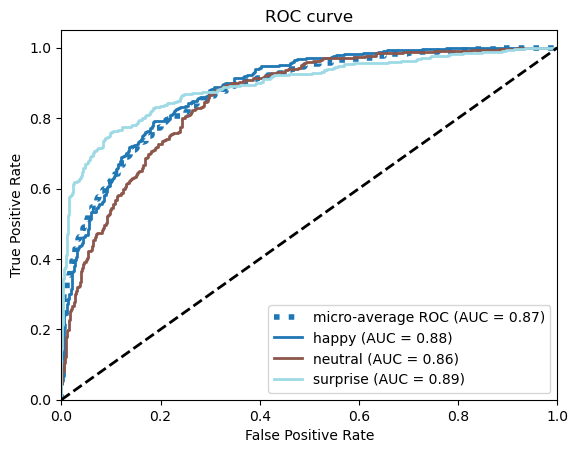

--------------------------------------------------------------------------------------------------------
AffectNetHQ
--------------------------------------------------------------------------------------------------------
train_images: 6400
val_images: 1600
test_images: 2000


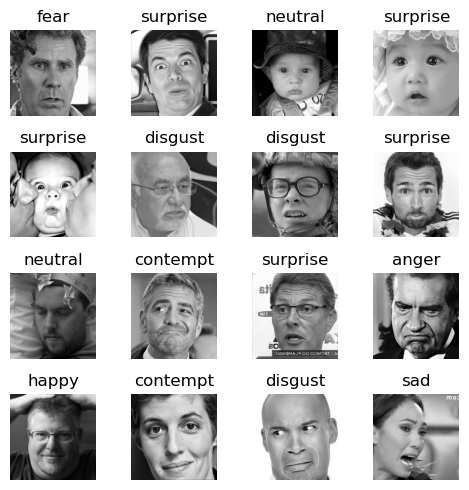

--------------------------------------------------------------------------------------------------------
resnet18_AffectNetHQ
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 990.436 billion


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 1/25 | Train Loss: 1.7177 | Train Acc: 0.2969 | Val Loss: 1.2575 | Val Acc: 0.3731


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 2/25 | Train Loss: 1.4288 | Train Acc: 0.4366 | Val Loss: 1.2580 | Val Acc: 0.3638


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 3/25 | Train Loss: 1.3046 | Train Acc: 0.4898 | Val Loss: 1.1253 | Val Acc: 0.4338


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 4/25 | Train Loss: 1.2061 | Train Acc: 0.5242 | Val Loss: 1.6573 | Val Acc: 0.3069


100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


Epoch 5/25 | Train Loss: 1.1349 | Train Acc: 0.5586 | Val Loss: 1.4128 | Val Acc: 0.3981


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 6/25 | Train Loss: 1.0494 | Train Acc: 0.5956 | Val Loss: 1.2084 | Val Acc: 0.4656


100%|██████████| 13/13 [00:04<00:00,  2.66it/s]


Epoch 7/25 | Train Loss: 1.0008 | Train Acc: 0.6225 | Val Loss: 1.1092 | Val Acc: 0.4825


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 8/25 | Train Loss: 0.9159 | Train Acc: 0.6594 | Val Loss: 1.2515 | Val Acc: 0.4644


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 9/25 | Train Loss: 0.8405 | Train Acc: 0.6925 | Val Loss: 1.0743 | Val Acc: 0.5044


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 10/25 | Train Loss: 0.7500 | Train Acc: 0.7242 | Val Loss: 1.1482 | Val Acc: 0.5194


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 11/25 | Train Loss: 0.6643 | Train Acc: 0.7556 | Val Loss: 1.6159 | Val Acc: 0.4450


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 12/25 | Train Loss: 0.5776 | Train Acc: 0.7988 | Val Loss: 1.1596 | Val Acc: 0.5456


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 13/25 | Train Loss: 0.4754 | Train Acc: 0.8284 | Val Loss: 1.4529 | Val Acc: 0.5194


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 14/25 | Train Loss: 0.3537 | Train Acc: 0.8772 | Val Loss: 1.2908 | Val Acc: 0.5500


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 15/25 | Train Loss: 0.3176 | Train Acc: 0.8923 | Val Loss: 1.4330 | Val Acc: 0.5281


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Epoch 16/25 | Train Loss: 0.2473 | Train Acc: 0.9191 | Val Loss: 1.5529 | Val Acc: 0.5288


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 17/25 | Train Loss: 0.1910 | Train Acc: 0.9367 | Val Loss: 1.6519 | Val Acc: 0.5069


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 18/25 | Train Loss: 0.1618 | Train Acc: 0.9498 | Val Loss: 1.5580 | Val Acc: 0.5225


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 19/25 | Train Loss: 0.1399 | Train Acc: 0.9581 | Val Loss: 1.6345 | Val Acc: 0.5294


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 20/25 | Train Loss: 0.1137 | Train Acc: 0.9663 | Val Loss: 1.5887 | Val Acc: 0.5338


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 21/25 | Train Loss: 0.0985 | Train Acc: 0.9727 | Val Loss: 1.6264 | Val Acc: 0.5513


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 22/25 | Train Loss: 0.0981 | Train Acc: 0.9691 | Val Loss: 1.7417 | Val Acc: 0.5125


100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 23/25 | Train Loss: 0.0849 | Train Acc: 0.9780 | Val Loss: 1.9016 | Val Acc: 0.5369


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 24/25 | Train Loss: 0.0692 | Train Acc: 0.9825 | Val Loss: 1.9929 | Val Acc: 0.5150


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 25/25 | Train Loss: 0.0641 | Train Acc: 0.9822 | Val Loss: 1.6417 | Val Acc: 0.5506
Average time per epoch: 34.17 seconds


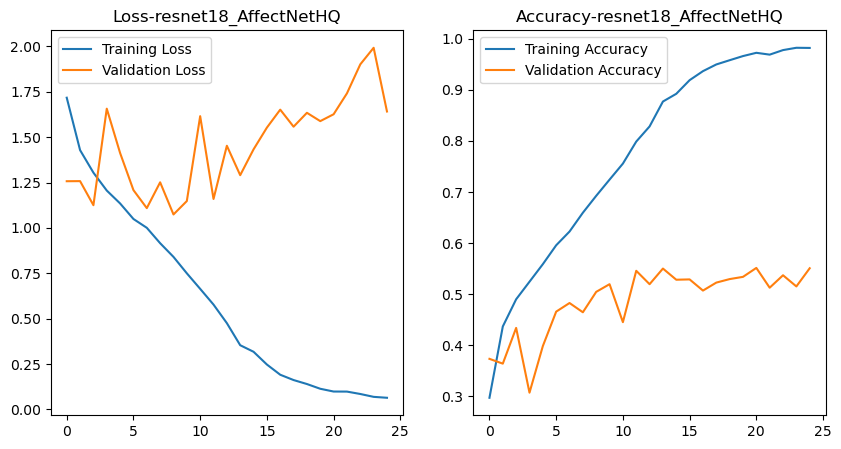

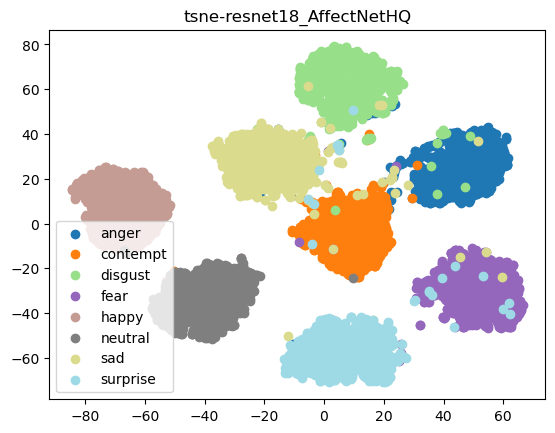

100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


Test Results:
Test Accuracy: 0.5880

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       250
           1       0.58      0.68      0.62       250
           2       0.62      0.29      0.40       250
           3       0.48      0.41      0.44       250
           4       0.88      0.89      0.89       250
           5       0.77      0.86      0.81       250
           6       0.50      0.39      0.44       250
           7       0.49      0.62      0.55       250

    accuracy                           0.59      2000
   macro avg       0.59      0.59      0.58      2000
weighted avg       0.59      0.59      0.58      2000



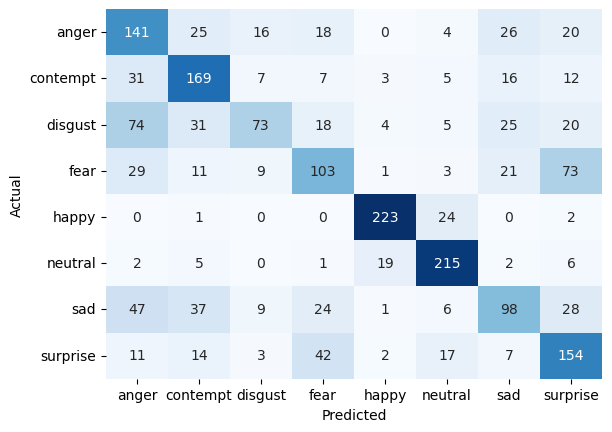

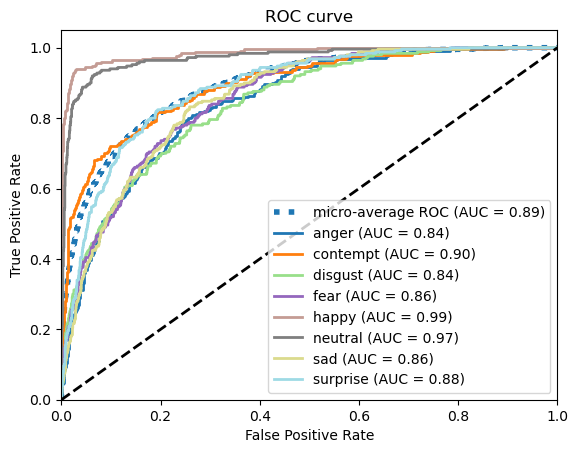

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


--------------------------------------------------------------------------------------------------------
mobilenet_v2_AffectNetHQ
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 4018.565 billion


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 1/25 | Train Loss: 1.9995 | Train Acc: 0.1922 | Val Loss: 2.9860 | Val Acc: 0.1250


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 2/25 | Train Loss: 1.6727 | Train Acc: 0.2872 | Val Loss: 1.3789 | Val Acc: 0.3013


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 3/25 | Train Loss: 1.5414 | Train Acc: 0.3598 | Val Loss: 1.3129 | Val Acc: 0.3294


100%|██████████| 13/13 [00:05<00:00,  2.60it/s]


Epoch 4/25 | Train Loss: 1.4342 | Train Acc: 0.4166 | Val Loss: 1.3006 | Val Acc: 0.3544


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 5/25 | Train Loss: 1.3220 | Train Acc: 0.4733 | Val Loss: 1.2980 | Val Acc: 0.3731


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 6/25 | Train Loss: 1.2478 | Train Acc: 0.5116 | Val Loss: 1.1417 | Val Acc: 0.4438


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 7/25 | Train Loss: 1.1687 | Train Acc: 0.5473 | Val Loss: 1.2349 | Val Acc: 0.4331


100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 8/25 | Train Loss: 1.1009 | Train Acc: 0.5834 | Val Loss: 1.2157 | Val Acc: 0.4612


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 9/25 | Train Loss: 1.0472 | Train Acc: 0.6048 | Val Loss: 1.2126 | Val Acc: 0.4600


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 10/25 | Train Loss: 1.0104 | Train Acc: 0.6195 | Val Loss: 1.2445 | Val Acc: 0.4431


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 11/25 | Train Loss: 0.9450 | Train Acc: 0.6508 | Val Loss: 1.2411 | Val Acc: 0.4769


100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 12/25 | Train Loss: 0.8703 | Train Acc: 0.6767 | Val Loss: 1.1584 | Val Acc: 0.4963


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 13/25 | Train Loss: 0.8183 | Train Acc: 0.6980 | Val Loss: 1.3877 | Val Acc: 0.4612


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 14/25 | Train Loss: 0.7612 | Train Acc: 0.7222 | Val Loss: 1.4253 | Val Acc: 0.4587


100%|██████████| 13/13 [00:05<00:00,  2.51it/s]


Epoch 15/25 | Train Loss: 0.7229 | Train Acc: 0.7320 | Val Loss: 1.3698 | Val Acc: 0.4856


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 16/25 | Train Loss: 0.6678 | Train Acc: 0.7558 | Val Loss: 1.3235 | Val Acc: 0.4794


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 17/25 | Train Loss: 0.6106 | Train Acc: 0.7827 | Val Loss: 1.5286 | Val Acc: 0.4850


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 18/25 | Train Loss: 0.5937 | Train Acc: 0.7889 | Val Loss: 1.3740 | Val Acc: 0.4844


100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


Epoch 19/25 | Train Loss: 0.5187 | Train Acc: 0.8159 | Val Loss: 1.5108 | Val Acc: 0.4875
Early stopping at epoch 19
Average time per epoch: 40.31 seconds


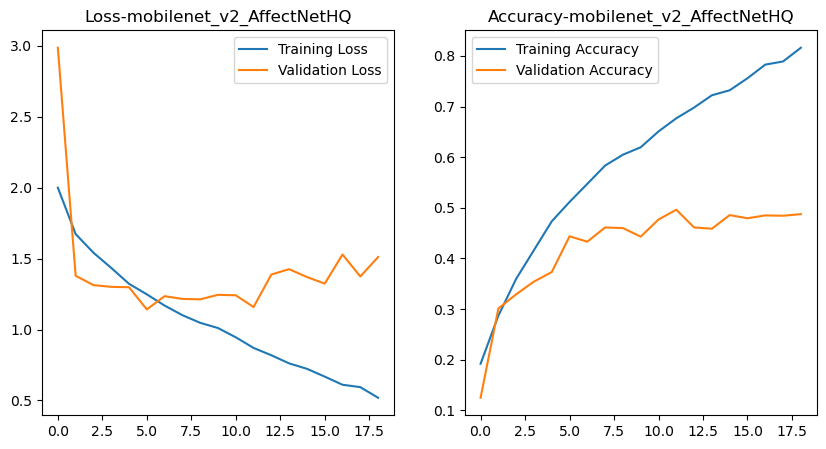

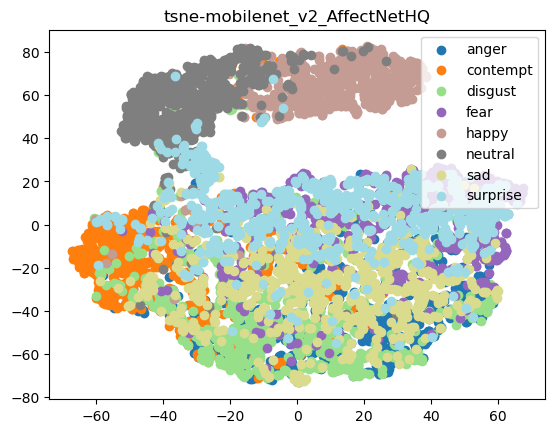

100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


Test Results:
Test Accuracy: 0.5170

              precision    recall  f1-score   support

           0       0.42      0.50      0.46       250
           1       0.47      0.66      0.55       250
           2       0.36      0.30      0.33       250
           3       0.38      0.43      0.40       250
           4       0.87      0.82      0.85       250
           5       0.78      0.77      0.78       250
           6       0.48      0.23      0.31       250
           7       0.41      0.41      0.41       250

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.51      2000



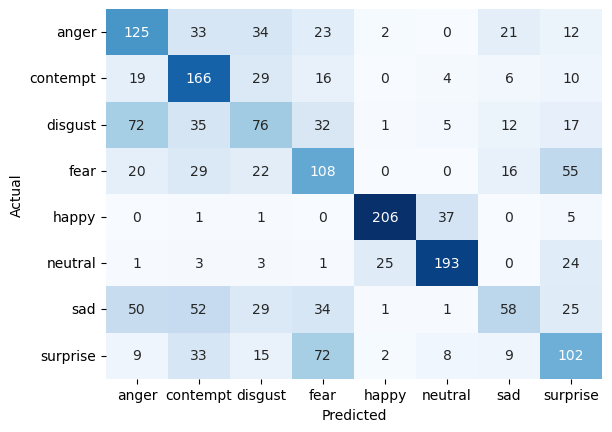

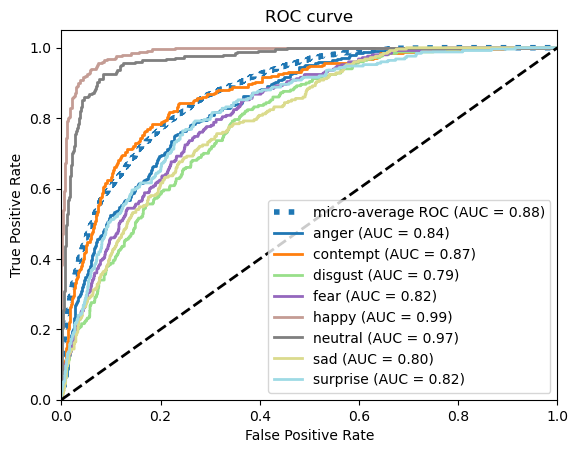

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


--------------------------------------------------------------------------------------------------------
shufflenet_v2_x1_0_AffectNetHQ
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 393.202 billion


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


Epoch 1/25 | Train Loss: 1.9435 | Train Acc: 0.2052 | Val Loss: 1.5477 | Val Acc: 0.2156


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 2/25 | Train Loss: 1.6771 | Train Acc: 0.2816 | Val Loss: 1.3729 | Val Acc: 0.3006


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 3/25 | Train Loss: 1.5643 | Train Acc: 0.3381 | Val Loss: 1.3477 | Val Acc: 0.3350


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 4/25 | Train Loss: 1.4764 | Train Acc: 0.3970 | Val Loss: 1.2582 | Val Acc: 0.3825


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Epoch 5/25 | Train Loss: 1.3766 | Train Acc: 0.4416 | Val Loss: 1.3176 | Val Acc: 0.3369


100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


Epoch 6/25 | Train Loss: 1.3091 | Train Acc: 0.4825 | Val Loss: 1.1996 | Val Acc: 0.4131


100%|██████████| 13/13 [00:04<00:00,  2.88it/s]


Epoch 7/25 | Train Loss: 1.2305 | Train Acc: 0.5162 | Val Loss: 1.1622 | Val Acc: 0.4413


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 8/25 | Train Loss: 1.1873 | Train Acc: 0.5405 | Val Loss: 1.1746 | Val Acc: 0.4125


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 9/25 | Train Loss: 1.1043 | Train Acc: 0.5725 | Val Loss: 1.3140 | Val Acc: 0.4012


100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


Epoch 10/25 | Train Loss: 1.0228 | Train Acc: 0.6125 | Val Loss: 1.3361 | Val Acc: 0.4100


100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


Epoch 11/25 | Train Loss: 0.9445 | Train Acc: 0.6502 | Val Loss: 1.3483 | Val Acc: 0.4369


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 12/25 | Train Loss: 0.8706 | Train Acc: 0.6772 | Val Loss: 1.4995 | Val Acc: 0.4181


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Epoch 13/25 | Train Loss: 0.8280 | Train Acc: 0.6916 | Val Loss: 1.3372 | Val Acc: 0.4506


100%|██████████| 13/13 [00:04<00:00,  2.94it/s]


Epoch 14/25 | Train Loss: 0.7553 | Train Acc: 0.7267 | Val Loss: 1.5958 | Val Acc: 0.4225


100%|██████████| 13/13 [00:04<00:00,  2.83it/s]


Epoch 15/25 | Train Loss: 0.6786 | Train Acc: 0.7591 | Val Loss: 1.4368 | Val Acc: 0.4450


100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 16/25 | Train Loss: 0.6268 | Train Acc: 0.7761 | Val Loss: 1.7245 | Val Acc: 0.4219


100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


Epoch 17/25 | Train Loss: 0.5650 | Train Acc: 0.7986 | Val Loss: 1.5537 | Val Acc: 0.4444


100%|██████████| 13/13 [00:04<00:00,  2.92it/s]


Epoch 18/25 | Train Loss: 0.5158 | Train Acc: 0.8239 | Val Loss: 1.5350 | Val Acc: 0.4419


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


Epoch 19/25 | Train Loss: 0.4743 | Train Acc: 0.8356 | Val Loss: 1.5453 | Val Acc: 0.4719


100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch 20/25 | Train Loss: 0.4131 | Train Acc: 0.8573 | Val Loss: 1.8332 | Val Acc: 0.4419


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 21/25 | Train Loss: 0.3759 | Train Acc: 0.8727 | Val Loss: 1.6723 | Val Acc: 0.4731


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


Epoch 22/25 | Train Loss: 0.3588 | Train Acc: 0.8741 | Val Loss: 1.6564 | Val Acc: 0.4662


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 23/25 | Train Loss: 0.3655 | Train Acc: 0.8778 | Val Loss: 1.6808 | Val Acc: 0.4681


100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


Epoch 24/25 | Train Loss: 0.2814 | Train Acc: 0.9034 | Val Loss: 1.6290 | Val Acc: 0.4725


100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 25/25 | Train Loss: 0.2581 | Train Acc: 0.9127 | Val Loss: 1.7768 | Val Acc: 0.4681
Average time per epoch: 30.23 seconds


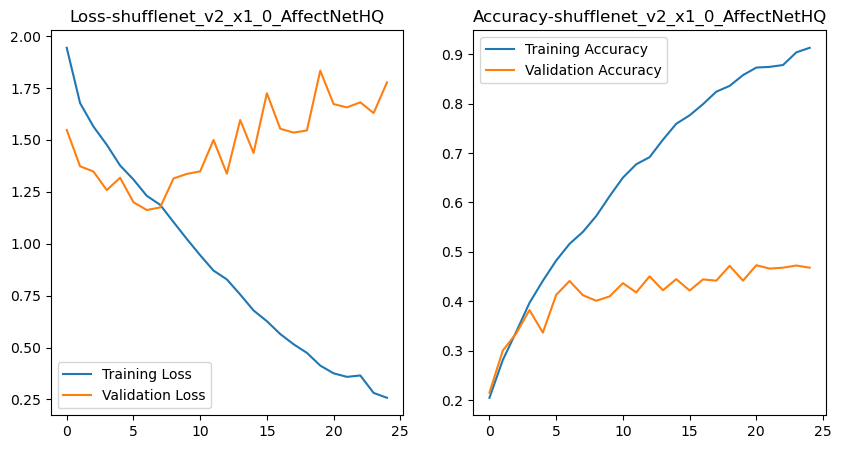

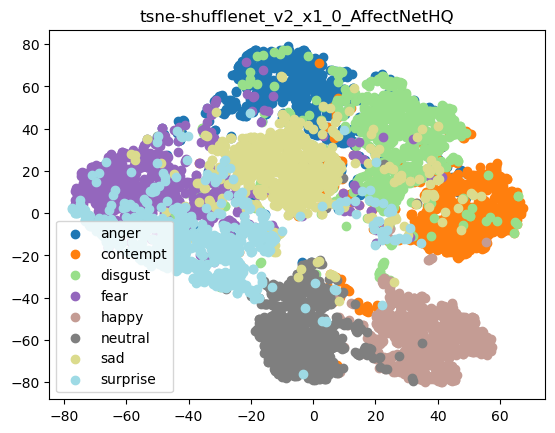

100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


Test Results:
Test Accuracy: 0.4695

              precision    recall  f1-score   support

           0       0.36      0.53      0.43       250
           1       0.48      0.34      0.40       250
           2       0.27      0.32      0.29       250
           3       0.36      0.40      0.38       250
           4       0.83      0.76      0.79       250
           5       0.70      0.78      0.74       250
           6       0.37      0.19      0.25       250
           7       0.46      0.44      0.45       250

    accuracy                           0.47      2000
   macro avg       0.48      0.47      0.47      2000
weighted avg       0.48      0.47      0.47      2000



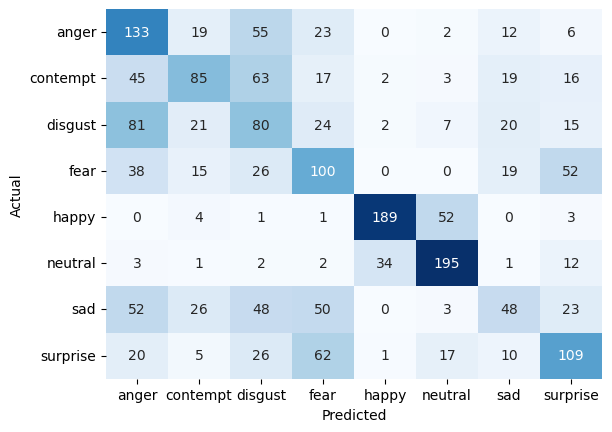

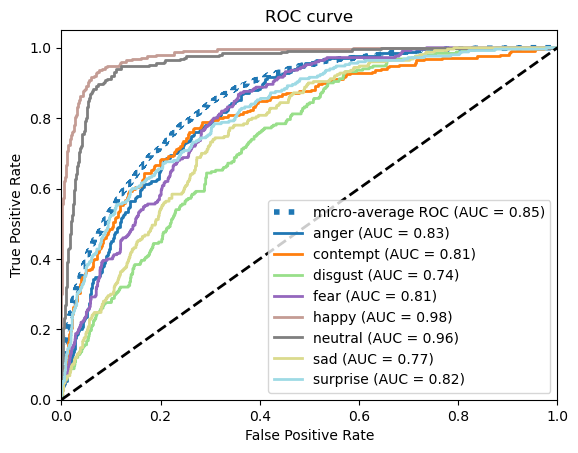

--------------------------------------------------------------------------------------------------------
Tiny
--------------------------------------------------------------------------------------------------------
train_images: 9620
val_images: 2470
test_images: 2990


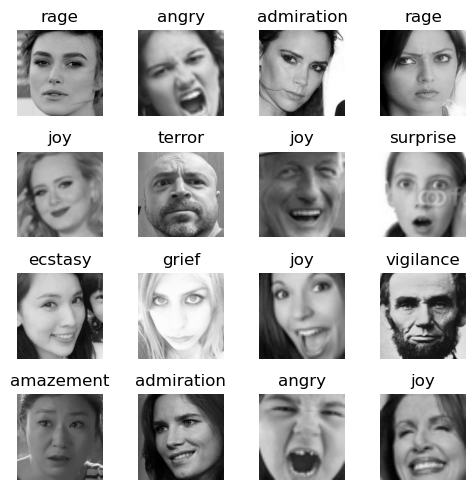

--------------------------------------------------------------------------------------------------------
resnet18_Tiny
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 990.436 billion


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch 1/25 | Train Loss: 2.1364 | Train Acc: 0.1718 | Val Loss: 3.4705 | Val Acc: 0.1211


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Epoch 2/25 | Train Loss: 1.9149 | Train Acc: 0.2298 | Val Loss: 1.6816 | Val Acc: 0.2049


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 3/25 | Train Loss: 1.8222 | Train Acc: 0.2791 | Val Loss: 2.6217 | Val Acc: 0.1579


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Epoch 4/25 | Train Loss: 1.6492 | Train Acc: 0.3619 | Val Loss: 3.5467 | Val Acc: 0.1150


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 5/25 | Train Loss: 1.5520 | Train Acc: 0.3956 | Val Loss: 3.4413 | Val Acc: 0.1729


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Epoch 6/25 | Train Loss: 1.4680 | Train Acc: 0.4349 | Val Loss: 1.2915 | Val Acc: 0.3834


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 7/25 | Train Loss: 1.3934 | Train Acc: 0.4545 | Val Loss: 1.4205 | Val Acc: 0.3713


100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


Epoch 8/25 | Train Loss: 1.3390 | Train Acc: 0.4738 | Val Loss: 1.6331 | Val Acc: 0.3470


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Epoch 9/25 | Train Loss: 1.2643 | Train Acc: 0.5079 | Val Loss: 1.5289 | Val Acc: 0.3798


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


Epoch 10/25 | Train Loss: 1.2094 | Train Acc: 0.5367 | Val Loss: 1.4790 | Val Acc: 0.4081


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


Epoch 11/25 | Train Loss: 1.1411 | Train Acc: 0.5644 | Val Loss: 1.2908 | Val Acc: 0.4336


100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Epoch 12/25 | Train Loss: 1.0978 | Train Acc: 0.5871 | Val Loss: 2.3412 | Val Acc: 0.3312


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 13/25 | Train Loss: 1.0191 | Train Acc: 0.6210 | Val Loss: 1.4062 | Val Acc: 0.4178


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Epoch 14/25 | Train Loss: 0.9245 | Train Acc: 0.6538 | Val Loss: 2.3844 | Val Acc: 0.3696


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 15/25 | Train Loss: 0.8678 | Train Acc: 0.6777 | Val Loss: 0.9779 | Val Acc: 0.5704


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Epoch 16/25 | Train Loss: 0.7597 | Train Acc: 0.7218 | Val Loss: 1.0666 | Val Acc: 0.5717


100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


Epoch 17/25 | Train Loss: 0.6479 | Train Acc: 0.7660 | Val Loss: 1.2422 | Val Acc: 0.5283


100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Epoch 18/25 | Train Loss: 0.5550 | Train Acc: 0.8020 | Val Loss: 3.2755 | Val Acc: 0.2405


100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


Epoch 19/25 | Train Loss: 0.4182 | Train Acc: 0.8587 | Val Loss: 1.4324 | Val Acc: 0.5024


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 20/25 | Train Loss: 0.3485 | Train Acc: 0.8854 | Val Loss: 2.0340 | Val Acc: 0.4413


100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


Epoch 21/25 | Train Loss: 0.3254 | Train Acc: 0.8878 | Val Loss: 3.4253 | Val Acc: 0.3648


100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


Epoch 22/25 | Train Loss: 0.2630 | Train Acc: 0.9126 | Val Loss: 2.4187 | Val Acc: 0.4223


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Epoch 23/25 | Train Loss: 0.1897 | Train Acc: 0.9391 | Val Loss: 1.1618 | Val Acc: 0.6672


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Epoch 24/25 | Train Loss: 0.1594 | Train Acc: 0.9501 | Val Loss: 1.1307 | Val Acc: 0.6883


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Epoch 25/25 | Train Loss: 0.1546 | Train Acc: 0.9495 | Val Loss: 1.1844 | Val Acc: 0.6696
Average time per epoch: 49.65 seconds


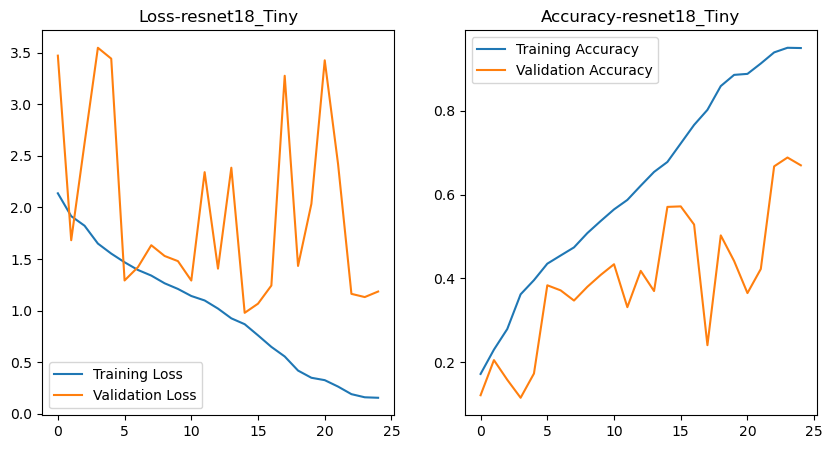

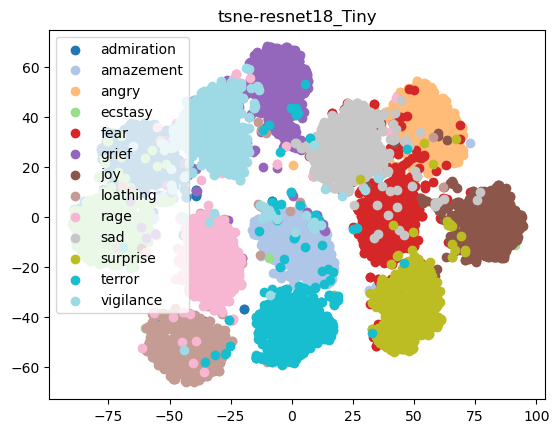

100%|██████████| 24/24 [00:24<00:00,  1.02s/it]


Test Results:
Test Accuracy: 0.6796

              precision    recall  f1-score   support

           0       0.53      0.85      0.65       230
           1       0.64      0.76      0.69       230
           2       0.89      0.51      0.65       230
           3       0.80      0.72      0.76       230
           4       0.70      0.56      0.62       230
           5       0.65      0.72      0.69       230
           6       0.92      0.61      0.73       230
           7       0.66      0.73      0.69       230
           8       0.95      0.42      0.58       230
           9       0.79      0.63      0.70       230
          10       0.55      0.96      0.70       230
          11       0.78      0.66      0.71       230
          12       0.56      0.71      0.63       230

    accuracy                           0.68      2990
   macro avg       0.73      0.68      0.68      2990
weighted avg       0.73      0.68      0.68      2990



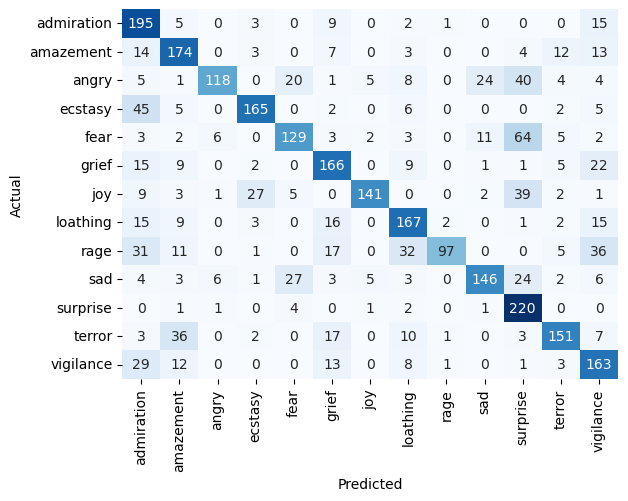

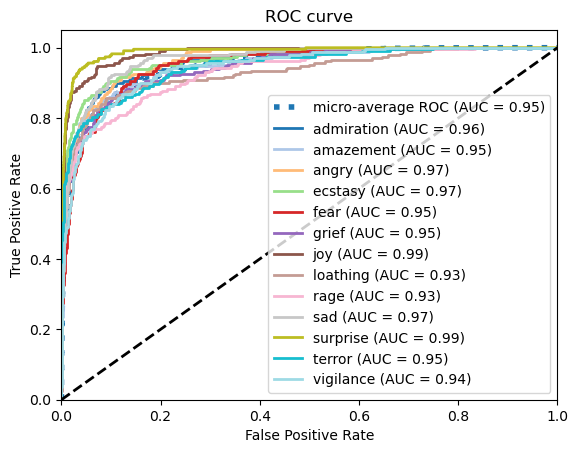

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


--------------------------------------------------------------------------------------------------------
mobilenet_v2_Tiny
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 4018.565 billion


100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


Epoch 1/25 | Train Loss: 2.1129 | Train Acc: 0.1576 | Val Loss: 3.0450 | Val Acc: 0.0927


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Epoch 2/25 | Train Loss: 1.8950 | Train Acc: 0.2334 | Val Loss: 1.9367 | Val Acc: 0.2126


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 3/25 | Train Loss: 1.7625 | Train Acc: 0.2992 | Val Loss: 1.5974 | Val Acc: 0.2652


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 4/25 | Train Loss: 1.6607 | Train Acc: 0.3535 | Val Loss: 1.3761 | Val Acc: 0.3494


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 5/25 | Train Loss: 1.5812 | Train Acc: 0.3786 | Val Loss: 1.7048 | Val Acc: 0.2895


100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


Epoch 6/25 | Train Loss: 1.5004 | Train Acc: 0.4163 | Val Loss: 1.3113 | Val Acc: 0.3862


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 7/25 | Train Loss: 1.4199 | Train Acc: 0.4508 | Val Loss: 1.4484 | Val Acc: 0.3765


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 8/25 | Train Loss: 1.3671 | Train Acc: 0.4740 | Val Loss: 1.2984 | Val Acc: 0.4231


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]


Epoch 9/25 | Train Loss: 1.3148 | Train Acc: 0.4884 | Val Loss: 1.1804 | Val Acc: 0.4607


100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


Epoch 10/25 | Train Loss: 1.2538 | Train Acc: 0.5141 | Val Loss: 1.1617 | Val Acc: 0.4798


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Epoch 11/25 | Train Loss: 1.1982 | Train Acc: 0.5401 | Val Loss: 1.1171 | Val Acc: 0.4866


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


Epoch 12/25 | Train Loss: 1.1498 | Train Acc: 0.5631 | Val Loss: 1.1534 | Val Acc: 0.4785


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Epoch 13/25 | Train Loss: 1.0955 | Train Acc: 0.5789 | Val Loss: 1.0676 | Val Acc: 0.5231


100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


Epoch 14/25 | Train Loss: 1.0522 | Train Acc: 0.6021 | Val Loss: 1.1982 | Val Acc: 0.5004


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Epoch 15/25 | Train Loss: 1.0089 | Train Acc: 0.6162 | Val Loss: 1.2922 | Val Acc: 0.4664


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Epoch 16/25 | Train Loss: 0.9608 | Train Acc: 0.6369 | Val Loss: 1.0909 | Val Acc: 0.5433


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


Epoch 17/25 | Train Loss: 0.9290 | Train Acc: 0.6518 | Val Loss: 0.9720 | Val Acc: 0.5955


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Epoch 18/25 | Train Loss: 0.8676 | Train Acc: 0.6811 | Val Loss: 1.0032 | Val Acc: 0.5806


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


Epoch 19/25 | Train Loss: 0.8514 | Train Acc: 0.6871 | Val Loss: 0.9122 | Val Acc: 0.6186


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


Epoch 20/25 | Train Loss: 0.7541 | Train Acc: 0.7242 | Val Loss: 1.0610 | Val Acc: 0.5923


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Epoch 21/25 | Train Loss: 0.6760 | Train Acc: 0.7496 | Val Loss: 0.9596 | Val Acc: 0.6308


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Epoch 22/25 | Train Loss: 0.6533 | Train Acc: 0.7607 | Val Loss: 1.1753 | Val Acc: 0.5506


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Epoch 23/25 | Train Loss: 0.6609 | Train Acc: 0.7601 | Val Loss: 1.0792 | Val Acc: 0.5984


100%|██████████| 20/20 [00:07<00:00,  2.59it/s]


Epoch 24/25 | Train Loss: 0.5674 | Train Acc: 0.7969 | Val Loss: 1.0769 | Val Acc: 0.6190


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Epoch 25/25 | Train Loss: 0.5743 | Train Acc: 0.7900 | Val Loss: 0.9320 | Val Acc: 0.6619
Average time per epoch: 58.40 seconds


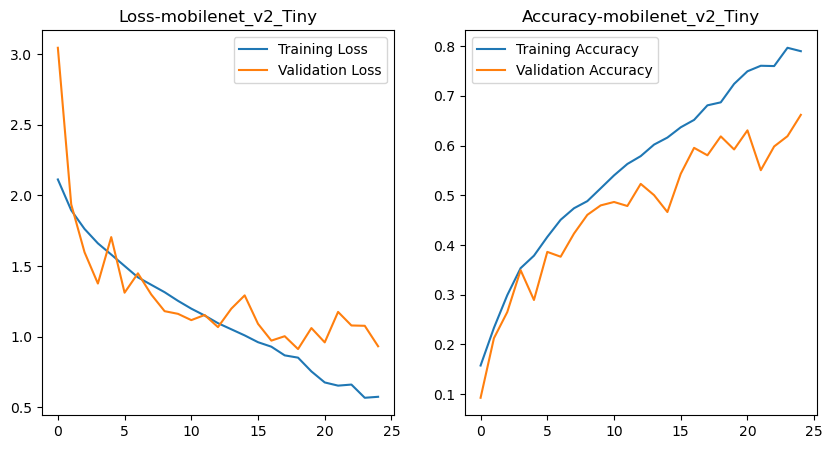

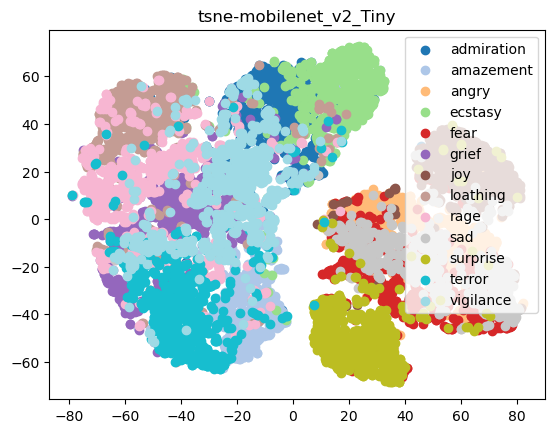

100%|██████████| 24/24 [00:11<00:00,  2.12it/s]


Test Results:
Test Accuracy: 0.6732

              precision    recall  f1-score   support

           0       0.65      0.60      0.62       230
           1       0.51      0.81      0.63       230
           2       0.81      0.62      0.70       230
           3       0.82      0.69      0.75       230
           4       0.64      0.60      0.62       230
           5       0.61      0.63      0.62       230
           6       0.90      0.77      0.83       230
           7       0.66      0.67      0.66       230
           8       0.73      0.58      0.65       230
           9       0.63      0.75      0.68       230
          10       0.71      0.87      0.78       230
          11       0.70      0.67      0.69       230
          12       0.58      0.50      0.53       230

    accuracy                           0.67      2990
   macro avg       0.69      0.67      0.67      2990
weighted avg       0.69      0.67      0.67      2990



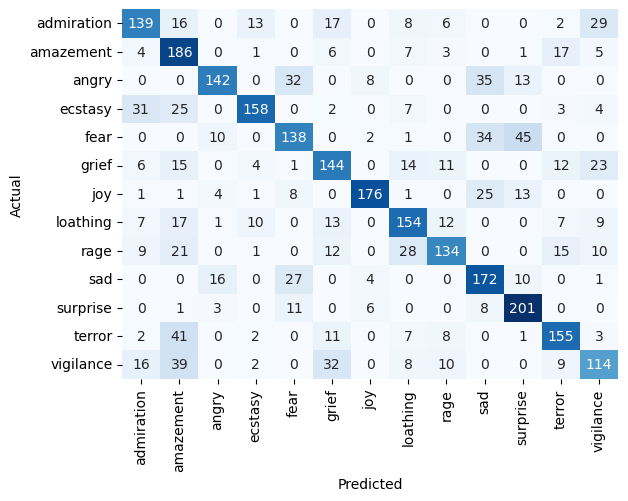

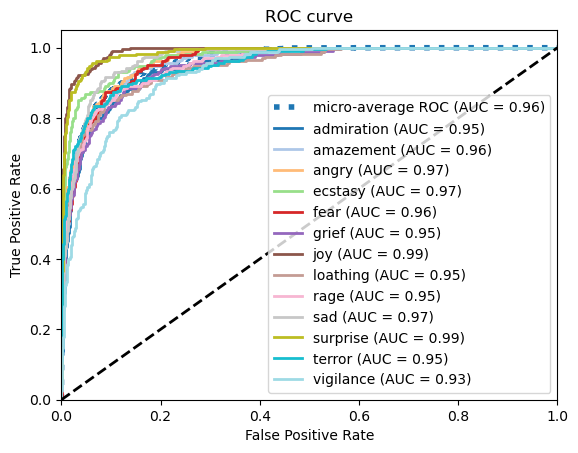

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


--------------------------------------------------------------------------------------------------------
shufflenet_v2_x1_0_Tiny
--------------------------------------------------------------------------------------------------------
Device: cuda
FLOPS: 393.202 billion


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 1/25 | Train Loss: 2.1450 | Train Acc: 0.1593 | Val Loss: 2.4579 | Val Acc: 0.1267


100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


Epoch 2/25 | Train Loss: 1.9438 | Train Acc: 0.2033 | Val Loss: 1.8017 | Val Acc: 0.2053


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


Epoch 3/25 | Train Loss: 1.8360 | Train Acc: 0.2736 | Val Loss: 1.6840 | Val Acc: 0.2595


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 4/25 | Train Loss: 1.7339 | Train Acc: 0.3178 | Val Loss: 1.5096 | Val Acc: 0.3178


100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


Epoch 5/25 | Train Loss: 1.6227 | Train Acc: 0.3664 | Val Loss: 1.3911 | Val Acc: 0.3559


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 6/25 | Train Loss: 1.5513 | Train Acc: 0.3897 | Val Loss: 1.3310 | Val Acc: 0.4045


100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


Epoch 7/25 | Train Loss: 1.4524 | Train Acc: 0.4290 | Val Loss: 1.2850 | Val Acc: 0.4049


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 8/25 | Train Loss: 1.3919 | Train Acc: 0.4655 | Val Loss: 2.0460 | Val Acc: 0.2644


100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


Epoch 9/25 | Train Loss: 1.3037 | Train Acc: 0.4978 | Val Loss: 1.3144 | Val Acc: 0.4101


100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


Epoch 10/25 | Train Loss: 1.2454 | Train Acc: 0.5223 | Val Loss: 2.2175 | Val Acc: 0.2231


100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


Epoch 11/25 | Train Loss: 1.1932 | Train Acc: 0.5478 | Val Loss: 1.1904 | Val Acc: 0.4543


100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


Epoch 12/25 | Train Loss: 1.1224 | Train Acc: 0.5692 | Val Loss: 2.5565 | Val Acc: 0.2490


100%|██████████| 20/20 [00:06<00:00,  3.20it/s]


Epoch 13/25 | Train Loss: 1.0697 | Train Acc: 0.5993 | Val Loss: 1.1838 | Val Acc: 0.5045


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 14/25 | Train Loss: 0.9879 | Train Acc: 0.6269 | Val Loss: 1.2447 | Val Acc: 0.4968


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Epoch 15/25 | Train Loss: 0.9100 | Train Acc: 0.6640 | Val Loss: 1.0462 | Val Acc: 0.5607


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 16/25 | Train Loss: 0.8607 | Train Acc: 0.6887 | Val Loss: 1.2140 | Val Acc: 0.5219


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


Epoch 17/25 | Train Loss: 0.8079 | Train Acc: 0.7054 | Val Loss: 1.0700 | Val Acc: 0.5656


100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


Epoch 18/25 | Train Loss: 0.7278 | Train Acc: 0.7356 | Val Loss: 0.9830 | Val Acc: 0.6028


100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


Epoch 19/25 | Train Loss: 0.6873 | Train Acc: 0.7556 | Val Loss: 1.1194 | Val Acc: 0.6004


100%|██████████| 20/20 [00:07<00:00,  2.86it/s]


Epoch 20/25 | Train Loss: 0.5856 | Train Acc: 0.7918 | Val Loss: 1.1564 | Val Acc: 0.5903


100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


Epoch 21/25 | Train Loss: 0.6384 | Train Acc: 0.7670 | Val Loss: 1.1426 | Val Acc: 0.5777


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Epoch 22/25 | Train Loss: 0.5413 | Train Acc: 0.8073 | Val Loss: 1.1832 | Val Acc: 0.6073


100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


Epoch 23/25 | Train Loss: 0.4881 | Train Acc: 0.8268 | Val Loss: 1.0552 | Val Acc: 0.6425


100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


Epoch 24/25 | Train Loss: 0.4789 | Train Acc: 0.8334 | Val Loss: 1.2397 | Val Acc: 0.5749


100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


Epoch 25/25 | Train Loss: 0.4440 | Train Acc: 0.8432 | Val Loss: 1.5250 | Val Acc: 0.5113
Average time per epoch: 43.72 seconds


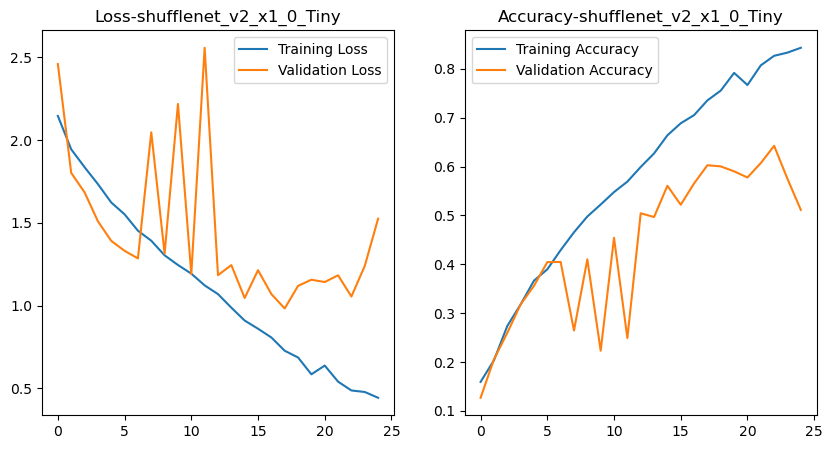

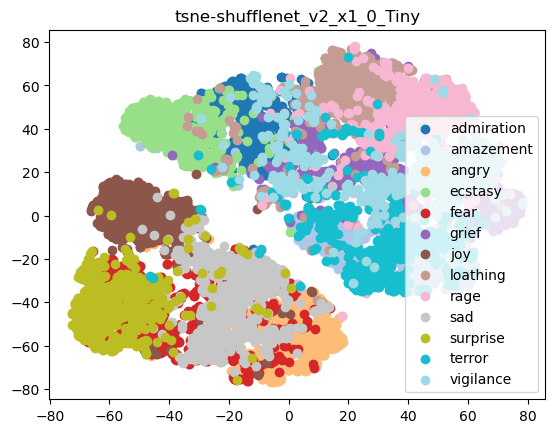

100%|██████████| 24/24 [00:10<00:00,  2.22it/s]


Test Results:
Test Accuracy: 0.6341

              precision    recall  f1-score   support

           0       0.79      0.51      0.62       230
           1       0.46      0.80      0.59       230
           2       0.60      0.69      0.64       230
           3       0.71      0.83      0.76       230
           4       0.69      0.47      0.56       230
           5       0.60      0.56      0.58       230
           6       0.83      0.77      0.80       230
           7       0.62      0.55      0.59       230
           8       0.56      0.71      0.63       230
           9       0.65      0.57      0.61       230
          10       0.77      0.78      0.77       230
          11       0.65      0.47      0.55       230
          12       0.53      0.52      0.53       230

    accuracy                           0.63      2990
   macro avg       0.65      0.63      0.63      2990
weighted avg       0.65      0.63      0.63      2990



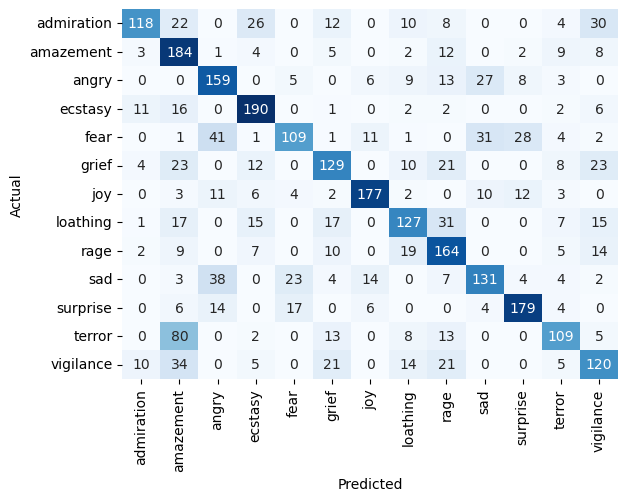

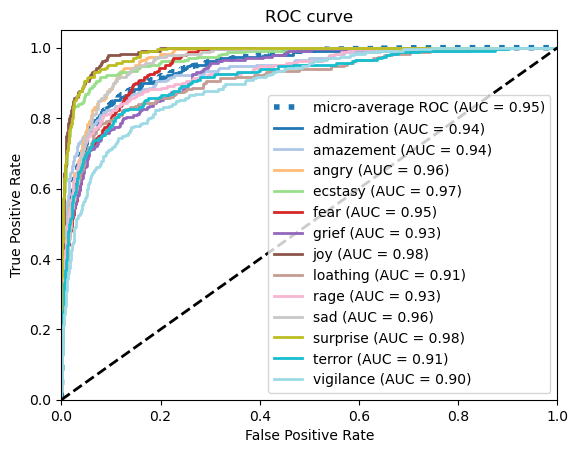

In [7]:
for data in ['fer2013/FER2013', 'affectnethq/AffectNetHQ', 'tinydataset/Tiny']:
    datasetName = data.split('/')[1]
    print('--------------------------------------------------------------------------------------------------------')
    print(datasetName)
    print('--------------------------------------------------------------------------------------------------------')
    train_dir = '/kaggle/input/'+data+'/train/'
    val_dir = '/kaggle/input/'+data+'/validation/'
    test_dir ='/kaggle/input/'+data+'/test/'

    train_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(train_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
    val_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(val_dir) for f in filenames if f.endswith(('.jpg', '.png'))]
    test_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(test_dir) for f in filenames if f.endswith(('.jpg', '.png'))]

    print('train_images:',len(train_images))
    print('val_images:',len(val_images))
    print('test_images:',len(test_images))

    train_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224))
        ])

    test_transforms = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((224, 224))
        ])

    device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
    torch.cuda.empty_cache()

    train_data = dataset(train_dir, train_transforms, device)
    train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)

    val_data = dataset(val_dir, train_transforms, device)
    val_loader = DataLoader(val_data, batch_size = 128, shuffle = True)

    test_data = dataset(test_dir, test_transforms, device)
    test_loader = DataLoader(test_data, batch_size = 128, shuffle = False)

    plot_data_loader(train_loader, (4, 4), train_data.class_names)

    for mdl in ['resnet18', 'mobilenet_v2', 'shufflenet_v2_x1_0']:
        print('--------------------------------------------------------------------------------------------------------')
        print(mdl+"_"+datasetName)
        print('--------------------------------------------------------------------------------------------------------')
        if mdl == 'resnet18':
            model = models.resnet18(pretrained=False)
            model.fc = torch.nn.Linear(model.fc.in_features, len(train_data.class_names))
        elif mdl == 'mobilenet_v2':
            model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=False)
            num_ftrs = model.classifier[1].in_features
            model.classifier = nn.Linear(num_ftrs, len(train_data.class_names))
            model.fc = nn.Linear(num_ftrs, len(train_data.class_names))
        elif mdl == 'shufflenet_v2_x1_0':
            model = torch.hub.load('pytorch/vision:v0.9.0', 'shufflenet_v2_x1_0', pretrained=False)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, len(train_data.class_names))

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.to(device)
        print("Device: {}".format(device))

        flops = 0
        for name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                flops += 2 * module.in_channels * module.out_channels * module.kernel_size[0] ** 2 * (224 // module.stride[0]) ** 2
            elif isinstance(module, torch.nn.Linear):
                flops += 2 * module.in_features * module.out_features

        print(f"FLOPS: {flops / 1e9:.3f} billion")


        start = time.time()

        num_epochs = 25
        patience = 7
        best_acc = 0  
        best_model = None

        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        for epoch in range(num_epochs):

            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = val_model(model, val_loader, criterion, device)

            print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if val_acc > best_acc:
                best_acc = val_acc
                epochs_no_improve = 0  
                best_model = copy.deepcopy(model)
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
        end = time.time()
        torch.save(best_model.state_dict(), mdl+'_'+datasetName+'.pth')
        print("Average time per epoch: {:.2f} seconds".format((end - start) / epoch))
        
        train_accs=torch.tensor(train_accs)
        val_accs = torch.tensor(val_accs)  

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(train_losses, label="Training Loss")
        axs[0].plot(val_losses, label="Validation Loss")
        axs[0].set_title("Loss-"+mdl+'_'+datasetName)
        axs[0].legend()

        val_accs = val_accs.cpu().numpy()  
        axs[1].plot(train_accs, label="Training Accuracy")
        axs[1].plot(val_accs, label="Validation Accuracy")
        axs[1].set_title("Accuracy-"+mdl+'_'+datasetName)
        axs[1].legend()

        plt.show()

        label_names = train_data.class_names
        cmap = colormap.get_cmap('tab20',len(label_names))
        colors = [cmap(i) for i in range(len(label_names))]
        features = []
        labels = []

        with torch.no_grad():
            for images, target in train_loader:
                images = images.to(device) 
                outputs = best_model(images)
                features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
                labels.append(target.cpu().numpy())

        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
        tsne = TSNE(n_components=2, random_state=0)
        tsne_features = tsne.fit_transform(features)

        for label_id in range(len(label_names)):
            mask = (labels == label_id).flatten()
            plt.scatter(tsne_features[mask, 0], tsne_features[mask, 1], c=colors[label_id], label=label_names[label_id])
        plt.legend()
        plt.title('tsne-'+mdl+'_'+datasetName)
        plt.show()

        test_model(best_model, test_loader, criterion, device)